# SST Tutorial (SHRED V1)

#### Load Libraries

In [348]:
%load_ext autoreload
%autoreload 2

from pyshred.processor.data_manager import DataManager
from pyshred.models import shred
from pyshred.latent_forecaster_models.sindy import SINDy_Forecaster
from pyshred.models.shred import SHRED
from pyshred.engine.engine import SHREDEngine
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading Data

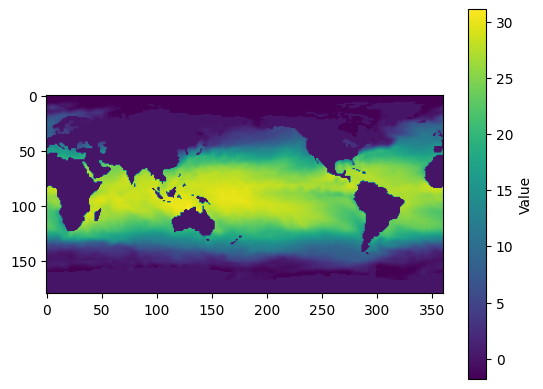

(1400, 180, 360)

In [349]:
mat = loadmat("SST_data.mat")          # load MATLAB file
arr = mat['Z'].T                   # extract the variable you want
arr = arr.reshape(1400, 180, 360)
# # Plotting
plt.figure()
plt.imshow(arr[0]) 
plt.colorbar(label="Value")
plt.show()
arr.shape


In [350]:
manager = DataManager(
    lags = 52,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1,
)

In [369]:
manager.add_data(
    data = arr,
    id = "SST2",
    random = 50,
    # stationary = [(46, 227),(120, 60),(134, 303)],
    # measurements=measurements,
    compress=False,
)

In [370]:
datasets = manager.prepare()

In [371]:
manager.sensor_summary_df

,data id,number,type,loc/traj
0,SST,0,stationary (random),"(99, 353)"
1,SST,1,stationary (random),"(112, 228)"
2,SST,2,stationary (random),"(38, 324)"
3,SST,3,stationary (random),"(58, 358)"
4,SST,4,stationary (random),"(17, 241)"
...,...,...,...,...
95,SST2,95,stationary (random),"(2, 303)"
96,SST2,96,stationary (random),"(170, 107)"
97,SST2,97,stationary (random),"(42, 62)"
98,SST2,98,stationary (random),"(154, 328)"


In [372]:
manager.sensor_measurements_df

data id,SST-0,SST-1,SST-2,SST-3,SST-4,SST-5,SST-6,SST-7,SST-8,SST-9,...,SST2-90,SST2-91,SST2-92,SST2-93,SST2-94,SST2-95,SST2-96,SST2-97,SST2-98,SST2-99
0,24.519999,27.219999,8.51,0.0,-1.75,26.849999,0.95,26.999999,24.309999,0.35,...,26.929999,0.0,23.329999,1.53,-1.8,-1.80,-0.0,0.0,-0.61,-1.78
1,24.109999,27.229999,8.21,0.0,-1.76,27.119999,0.81,26.679999,24.479999,0.26,...,27.369999,0.0,22.459999,1.60,-1.8,-1.80,-0.0,0.0,-0.22,-1.78
2,24.959999,27.009999,7.58,0.0,-1.77,26.639999,1.28,26.629999,24.799999,0.20,...,27.389999,0.0,23.369999,1.35,-1.8,-1.80,-0.0,0.0,-0.09,-1.78
3,25.069999,27.079999,7.41,0.0,-1.78,26.889999,0.97,26.599999,24.739999,0.05,...,27.519999,0.0,23.599999,1.41,-1.8,-1.80,-0.0,0.0,0.31,-1.79
4,25.009999,26.259999,7.05,0.0,-1.78,27.129999,1.14,26.769999,25.209999,0.06,...,27.549999,0.0,23.769999,1.91,-1.8,-1.80,-0.0,0.0,0.95,-1.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,22.919999,23.879999,11.78,0.0,2.99,27.709999,-0.73,29.249999,23.869999,-1.47,...,25.279999,0.0,17.810000,7.67,-1.8,-1.80,-0.0,0.0,-1.38,0.56
1396,23.089999,24.169999,11.04,0.0,2.12,27.729999,-0.76,28.669999,23.709999,-1.58,...,25.249999,0.0,17.880000,6.99,-1.8,-1.77,-0.0,0.0,-1.34,-0.33
1397,22.949999,24.389999,10.37,0.0,1.24,27.689999,-0.71,27.869999,24.089999,-1.65,...,25.449999,0.0,18.010000,6.71,-1.8,-1.77,-0.0,0.0,-1.30,-0.37
1398,23.429999,24.839999,10.61,0.0,0.55,28.139999,-0.49,28.779999,24.029999,-1.70,...,26.019999,0.0,18.400000,6.55,-1.8,-1.77,-0.0,0.0,-1.39,-0.82


In [376]:
latent_forecaster = SINDy_Forecaster(poly_order=1, include_sine=True, dt=1/5)
shred = SHRED(sequence_model="GRU", decoder_model="SDN", latent_forecaster=latent_forecaster)

In [377]:
val_errors = shred.fit(train_dataset=datasets[0], val_dataset=datasets[1], num_epochs=2, thres_epoch=20, sindy_regularization=1)

Fitting SindySHRED...
Epoch 1: Average training loss = 0.076012
Validation MSE (epoch 1): 0.020777
Epoch 2: Average training loss = 0.027216
Validation MSE (epoch 2): 0.012863


In [378]:
val_errors

array([0.02077688, 0.01286271], dtype=float32)

In [379]:
shred.evaluate(test_dataset=datasets[2])

0.014829150611128704

In [380]:
shred.latent_forecaster.model.print()

(x0)' = -1.503 1 + -1.510 x0 + 0.003 x1 + -0.001 x2
(x1)' = 0.553 1 + 2.560 x0 + 0.335 x1 + 2.311 x2
(x2)' = 1.658 1 + 1.351 x0 + -0.120 x1 + -0.347 x2


In [381]:
manager.val_sensor_measurements.shape

(140, 100)

In [ ]:
engine = SHREDEngine(manager, shred)
reconstructed_latent = engine.sensor_to_latent(manager.val_sensor_measurements)
latent = reconstructed_latent[-1]
# recon = engine.decode(latents = latent)
# recon

In [383]:
latent

array([-0.99717695, -0.7901181 ,  0.99183196], dtype=float32)

In [384]:
forecasted_latents = engine.forecast_latent(200, latent)

In [385]:
forecasted_recon = engine.decode(forecasted_latents)

In [ ]:
datum = {'SST2':arr[1260:,:],'SST':arr[1260:,:]}
# datum['SST'].shape
# datasets[0].Y.shape[0]+datasets[1].Y.shape[0]

engine.evaluate(manager.test_sensor_measurements, datum)

,MSE,RMSE,MAE,R2
dataset,,,,
SST2,0.774613,0.880121,0.509824,-1.250122
SST,0.780055,0.883207,0.515743,-1.983657


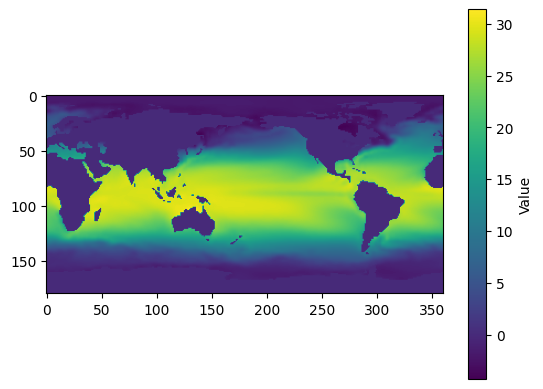

In [394]:
plt.figure()
plt.imshow(forecasted_recon['SST'][0]) 
plt.colorbar(label="Value")
plt.show()

In [366]:
# Rate of sparsity
torch.mean(shred.e_sindy.coefficient_mask*1.0)

tensor(1.)

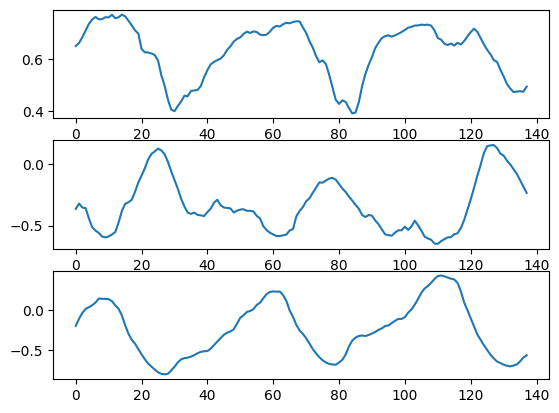

In [368]:

import matplotlib.pyplot as plt
import pysindy as ps
from pysindy.differentiation import FiniteDifference
gru_outs, sindy_outs = shred.gru_outputs(datasets[2].X, sindy=True)
differentiation_method = FiniteDifference()

latent_dim = 3
fig, ax = plt.subplots(latent_dim)
for i in range(latent_dim):
    ax[i].plot(gru_outs[1:,0,i].detach().cpu().numpy())

(x0)' = -2.060 1 + -2.848 x0 + 1.372 x1 + 5.323 x2
(x1)' = -13.937 1 + -0.944 x0 + -19.575 x1 + -3.915 x2
(x2)' = 8.554 1 + -2.257 x0 + 13.851 x1 + 4.975 x2


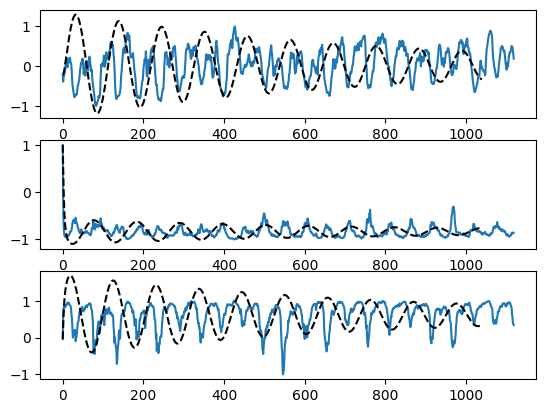

In [331]:
gru_outs, sindy_outs = shred.gru_outputs(datasets[0].X, sindy=True)
gru_outs = gru_outs[:,0,:]

poly_order = 1
threshold = 0.05

###############Normalization###############

gru_outs[:,0] = (gru_outs[:,0] - torch.min(gru_outs[:,0])) / (torch.max(gru_outs[:,0])-torch.min(gru_outs[:,0]))
gru_outs[:,1] = (gru_outs[:,1] - torch.min(gru_outs[:,1])) / (torch.max(gru_outs[:,1])-torch.min(gru_outs[:,1]))
gru_outs[:,2] = (gru_outs[:,2] - torch.min(gru_outs[:,2])) / (torch.max(gru_outs[:,2])-torch.min(gru_outs[:,2]))

gru_outs = 2 * gru_outs - 1

###############SINDy discovery###############

x = gru_outs.detach().cpu().numpy()

differentiation_method = ps.differentiation.FiniteDifference()
# differentiation_method = ps.differentiation.SmoothedFiniteDifference()

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.0, alpha=0.05),
    differentiation_method=differentiation_method,
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)

# model = ps.SINDy(
#     optimizer=ps.MIOSR(group_sparsity=(2,2,2), alpha=5000),
#     differentiation_method=differentiation_method,
#     feature_library=ps.PolynomialLibrary(degree=poly_order),
# )
import math
import numpy as np
np.math = math

t_points = np.arange(0, len(x)) * (1/52.0)
model.fit(x, t=t_points)
model.print()


###############Plot the discovered SINDy model###############

t_train = np.arange(0, 20, 1/52.0)
init_cond = np.zeros(latent_dim)
init_cond[:latent_dim] = gru_outs[0,:].detach().cpu().numpy()
x_sim = model.simulate(init_cond, t_train)

fig, ax = plt.subplots(latent_dim)
for i in range(latent_dim):
    ax[i].plot(gru_outs[:,i].detach().cpu().numpy())
    ax[i].plot(x_sim[:,i], "k--", label="model")